In [1]:
from keras.layers import Embedding, Dense, LSTM, Activation, Dropout, BatchNormalization, GRU, Input, SimpleRNN
from keras.models import Sequential, Model
from keras import regularizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from preprocessing2 import *

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def split_data(df, ratio, state=1):
    """
    :param ratio: test fraction
    :param state: random_state
    :return:
    """
    X = df.text
    y = df.author
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=state)
    return X_train, X_test, y_train, y_test

In [4]:
def encode_authors(labels):
    """
    :param labels: np.array or list of string authors
    :return: categorical list (for keras)
    """
    authors_vocab = {"EAP": 0, "HPL": 1, "MWS": 2}
    y = [authors_vocab[label] for label in labels]
    y = to_categorical(y, num_classes=3)
    return y

In [5]:
def encode_texts(text, embedding_vocab, embedding_size):
    emb_func = lambda sent: sentence_to_emb(sent, embedding_vocab, embedding_size)
    emb_texts = np.array([emb_func(sent) for sent in text])
    return emb_texts

In [6]:
train_df = create_df("final_train.csv")
X_train, X_test, y_train, y_test = split_data(train_df, 0.8)
X_train = X_train.apply(clean_text)
X_train = X_train.apply(lambda row: lemmatize_text(row))

X_test = X_test.apply(clean_text)
X_test = X_test.apply(lambda row: lemmatize_text(row))

In [7]:
vocab_size = 50000
vocab = get_vocabulary(X_train, length=vocab_size)
emb_vocab = embedding_mapping(vocab)
emb_vocab_size = len(emb_vocab)

In [8]:
embed_size = 64
X_train = encode_texts(X_train, emb_vocab, embed_size)
X_test = encode_texts(X_test, emb_vocab, embed_size)

In [9]:
y_train = encode_authors(y_train)
y_test = encode_authors(y_test)

In [10]:
num_epochs = 5
lstm_size = 50
batch_size = 64

In [11]:
from keras import regularizers

In [16]:
x = Input(shape=(None,), dtype='int32')
e = Embedding(emb_vocab_size, embed_size, mask_zero=True)(x)
r = GRU(lstm_size, return_sequences=False, recurrent_regularizer=regularizers.l2(0.01))(e)
#r = SimpleRNN(50, return_sequences=False)(e)
dr = Dropout(0.3)(r)
de = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dr)
dr2 = Dropout(0.3)(de)
p = Dense(3, activation='softmax')(dr2)

model = Model(x, p)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          2006912   
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                17250     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13056     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total para

In [18]:
#model = baseline_model(emb_vocab_size, embed_size, lstm_size)
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Train on 32928 samples, validate on 8233 samples
Epoch 1/5
32928/32928 [==============================] - 68s - loss: 0.8362 - acc: 0.6887 - val_loss: 0.4556 - val_acc: 0.8519
Epoch 2/5
32928/32928 [==============================] - 67s - loss: 0.3229 - acc: 0.9072 - val_loss: 0.4147 - val_acc: 0.8678
Epoch 3/5
32928/32928 [==============================] - 67s - loss: 0.2224 - acc: 0.9442 - val_loss: 0.4621 - val_acc: 0.8596
Epoch 4/5
32928/32928 [==============================] - 67s - loss: 0.1750 - acc: 0.9582 - val_loss: 0.4677 - val_acc: 0.8570
Epoch 5/5
32928/32928 [==============================] - 67s - loss: 0.1482 - acc: 0.9644 - val_loss: 0.5091 - val_acc: 0.8555


In [19]:
test_df = create_df("test.csv")

In [20]:
X_final_test = test_df.text

In [21]:
X_final_test = X_final_test.apply(lambda row: lemmatize_text(row))
X_final_test = X_final_test.apply(clean_text)

In [22]:
X_final_test = encode_texts(X_final_test, emb_vocab, embed_size)

In [23]:
prediction = model.predict(X_final_test)

In [49]:
from sklearn.metrics import log_loss

In [24]:
import copy

In [25]:
def oneHotVector(position, length):
    res = np.zeros(length)
    res[position] = 1
    return res

In [26]:
def improvePrediction(y_pred):
    res = copy.deepcopy(y_pred)
    for i in range(len(res)):
        for j in range(len(res[i])):
            if res[i][j] > 0.95:
                res[i] = oneHotVector(j, 3)
    return res

In [85]:
log_loss(y_pred=y_test, y_true=y_test)

2.1094237467877998e-15

In [27]:
def getPredictionFile(predictions, ids):
    pred_df = pd.DataFrame(columns=["id", "EAP", "HPL", "MWS"], index=None)
    pred_df.id = ids
    pred_df.EAP = predictions[:, 0]
    pred_df.HPL = predictions[:, 1]
    pred_df.MWS = predictions[:, 2]
    pred_df.to_csv("predictions.csv")

In [28]:
getPredictionFile(prediction, test_df.id)

In [76]:
val_pred

array([[  2.88258161e-04,   9.99627352e-01,   8.43776652e-05],
       [  9.58744407e-01,   1.11544295e-03,   4.01400700e-02],
       [  9.97029543e-01,   1.74714066e-03,   1.22329209e-03],
       ..., 
       [  2.55762693e-03,   9.96450305e-01,   9.92065296e-04],
       [  9.98799443e-01,   3.82900995e-04,   8.17582186e-04],
       [  9.99588788e-01,   1.49248095e-04,   2.61989800e-04]], dtype=float32)

In [81]:
improvePrediction(val_pred)

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]], dtype=float32)

In [42]:
prediction[:,0]

array([  1.51138264e-03,   4.12596524e-01,   8.92786011e-02, ...,
         9.92899776e-01,   1.84673036e-03,   3.52610186e-05], dtype=float32)

In [43]:
prediction

array([[  1.51138264e-03,   1.50843145e-04,   9.98337746e-01],
       [  4.12596524e-01,   5.78712523e-01,   8.69095884e-03],
       [  8.92786011e-02,   9.08937812e-01,   1.78364315e-03],
       ..., 
       [  9.92899776e-01,   2.72229430e-03,   4.37793462e-03],
       [  1.84673036e-03,   1.45370286e-04,   9.98007953e-01],
       [  3.52610186e-05,   9.99954939e-01,   9.82539950e-06]], dtype=float32)

In [30]:
word2num = emb_vocab
num2word = {v: k for k, v in word2num.items()}

In [18]:
from keras.preprocessing.text import text_to_word_sequence

In [19]:
embed = model.layers[1].get_weights()[0]
embed.shape

(24982, 64)

In [20]:
from sklearn.decomposition import PCA
embed_2d = PCA(n_components = 2).fit_transform(embed)
embed_2d.shape

(24982, 2)

In [56]:
def words2sequences(words):
    return [word2num[w]+3 if w in word2num else 2 for w in text_to_word_sequence(words)]

5780
12155
1493
903
9949
1987


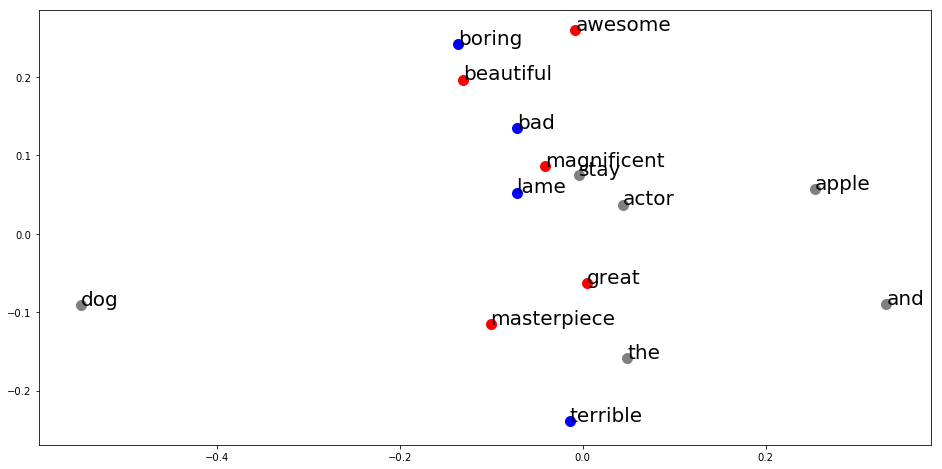

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
word_idx=[]
for word in ["great","awesome","beautiful","magnificent","masterpiece"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="red",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)
for word in ["bad", "terrible", "boring", "lame"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="blue",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

for word in ["actor", "apple", "stay", "dog","and","the"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="gray",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

plt.show()